# Perceptron for the OR problem in MLX

Markus Enzweiler, markus.enzweiler@hs-esslingen.de

This is a demo used in a Computer Vision & Machine Learning lecture. Feel free to use and contribute.

We build and train a perceptron to act as a simple OR gate with two inputs and one output. 
OR gates have the following behavior:

If both inputs are 0 (off), the output is 0 (off)
If both inputs are 1 (on), the output is 1 (on)
If either input is 1 (on), the output is still 1 (on)

| observation # | input 1 | input 2 | output |
|---------------|---------|---------|--------|
| 0             | 0       | 0       | 0      |
| 1             | 0       | 1       | 1      |
| 2             | 1       | 0       | 1      |
| 3             | 1       | 1       | 1      |




**Note: This requires a machine with an Apple SoC, e.g. M1/M2/M3 etc.**

See: https://github.com/ml-explore/mlx

## Setup

Adapt `packagePath` to point to the directory containing this notebeook.

In [32]:
# Imports
import sys
import os

In [33]:
# Package Path
package_path = "./" # local

# Colab specific stuff below.
# If you use Colab, change package_path to a path on your Google drive

def check_for_colab():
  try:
      import google.colab
      return True
  except ImportError:
      return False

# Running on Colab?
on_colab = check_for_colab()

# Google drive mount point
gdrive_mnt = '/content/drive'

# Mount Google Drive if on Colab
if on_colab:
  from google.colab import drive
  drive.mount(gdrive_mnt, force_remount=True)
  package_path = f"{gdrive_mnt}/MyDrive/colab/lecture_examples/cv-ml-lecture-notebooks/linear_regression"   # Colab


print(f"Package path: {package_path}")

Package path: ./


In [34]:
# Install requirements in the current Jupyter kernel
req_file = os.path.join(package_path, "requirements.txt")
if os.path.exists(req_file):
    !{sys.executable} -m pip install -r {req_file}
else:
    print(f"Requirements file not found: {req_file}")

In [35]:
# Now we should be able to import the additional packages
import numpy as np
import matplotlib.pyplot as plt
import mlx
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Set the random seed for reproducibility
np.random.seed(42)
mx.random.seed(42)


## Create the training data

In [36]:
# Define the training data for the OR problem in numpy


# Define the training data for the OR problem
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([0, 1, 1, 1])

# Convert numpy arrays to mlx tensors
X = mx.array(X, dtype=mx.float32)
Y = mx.array(Y, dtype=mx.float32)

print("Training data X with labels y:")
for i in range(len(X)):
    print(f"{X[i]} -> {Y[i]}")

Training data X with labels y:
array([0, 0], dtype=float32) -> array(0, dtype=float32)
array([0, 1], dtype=float32) -> array(1, dtype=float32)
array([1, 0], dtype=float32) -> array(1, dtype=float32)
array([1, 1], dtype=float32) -> array(1, dtype=float32)


# Define the Perceptron

## Perceptron class

In [37]:
## Replace our custom Perceptron class with PyTorch nn.Module and nn.Linear

class Perceptron(nn.Module):
    # override constructor from nn.Module
    def __init__(self, num_inputs):
        super().__init__() ## call constructor of nn.Module

        # we define the components of our perceptron
        # we want to have a linear layer with num_inputs inputs and one output
        self.linear = nn.Linear(input_dims=num_inputs, output_dims=1)
        self.sigmoid = mx.sigmoid

    def __call__(self, x):
        return self.forward(x)

    # override forward method from nn.Module
    def forward(self, x):
        # and the computation of the forward pass
        return self.sigmoid(self.linear(x))
        
    def print(self):
        print(f"Weights: {self.linear.weight}")
        print(f"Bias:    {self.linear.bias}")

## Create the Perceptron

In [38]:
# Perceptron for our OR problem
perceptron = Perceptron(num_inputs=2)
# Evaluate because mlx uses lazy evaluation
mx.eval(perceptron.parameters())
perceptron.print()

# All parameters of the perceptron are initialized randomly.
# Let's see the initial predictions for the training data X. 

def test(perceptron, X, Y):
    # test the perceptron on all data points
    print("Testing ...")
    for i in range(len(X)):
        prediction = perceptron(X[i])
        print(f"{X[i]} -> {prediction} (label: {Y[i]})")
        

print("Initial predictions before training:")
test(perceptron, X, Y)

Weights: array([[0.644855, -0.136793]], dtype=float32)
Bias:    array([0], dtype=float32)
Initial predictions before training:
Testing ...
array([0, 0], dtype=float32) -> array([0.5], dtype=float32) (label: array(0, dtype=float32))
array([0, 1], dtype=float32) -> array([0.465855], dtype=float32) (label: array(1, dtype=float32))
array([1, 0], dtype=float32) -> array([0.65585], dtype=float32) (label: array(1, dtype=float32))
array([1, 1], dtype=float32) -> array([0.624352], dtype=float32) (label: array(1, dtype=float32))


# Perceptron training with gradient descent

## Training

In [39]:
# Training 

# Train for 10000 training epochs with SGD
num_epochs = 10000
eta = 0.25

# We can use L2 (mean squared error) loss from mlx
def loss_fn(model, X, y):  
    return nn.losses.mse_loss((model(X)), y)

# Create the gradient function
loss_and_grad_fn = nn.value_and_grad(perceptron, loss_fn)

# Stochastic gradient descent (SGD) optimizer
optimizer = optim.SGD(learning_rate=eta)

# Loop over epochs
for epoch in range(num_epochs):

    # Reset accumulated loss per epoch
    acc_loss = 0

    # Loop over all training data
    for i in range(len(X)):          
       
        # forward and backward pass
        loss, gradients = loss_and_grad_fn(perceptron, X[i], Y[i].reshape(1,))     
        acc_loss += loss

        # Update the model with the gradients. So far no computation has happened.
        optimizer.update(perceptron, gradients)

        # Compute the new parameters and also the new optimizer state.
        mx.eval(perceptron.parameters(), optimizer.state)
    

    # Print accumulated average loss per epoch once in a while
    if (epoch % (num_epochs//10)) == 0 or epoch == num_epochs - 1:     
        print(f"Epoch {epoch:5d}: loss = {mx.mean(acc_loss).item():.5f}")


Epoch     0: loss = 0.78598
Epoch  1000: loss = 0.01150
Epoch  2000: loss = 0.00536
Epoch  3000: loss = 0.00346
Epoch  4000: loss = 0.00255
Epoch  5000: loss = 0.00201
Epoch  6000: loss = 0.00166
Epoch  7000: loss = 0.00141
Epoch  8000: loss = 0.00123
Epoch  9000: loss = 0.00109
Epoch  9999: loss = 0.00097


In [40]:
print("-------------------------------------------")
print(f"Perceptron after training for {num_epochs} epochs:")
perceptron.print()
test(perceptron, X, Y)

-------------------------------------------
Perceptron after training for 10000 epochs:
Weights: array([[7.9433, 7.9435]], dtype=float32)
Bias:    array([-3.73555], dtype=float32)
Testing ...
array([0, 0], dtype=float32) -> array([0.0233039], dtype=float32) (label: array(0, dtype=float32))
array([0, 1], dtype=float32) -> array([0.985341], dtype=float32) (label: array(1, dtype=float32))
array([1, 0], dtype=float32) -> array([0.985338], dtype=float32) (label: array(1, dtype=float32))
array([1, 1], dtype=float32) -> array([0.999995], dtype=float32) (label: array(1, dtype=float32))


# Visualize decision boundary

In [43]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


def show_decision_boundary(model, data, labels, subplot_spec=None):

    data   = np.array(data)
    labels = np.array(labels)

    wratio = (15, 1)
    if subplot_spec is None:
        gs = gridspec.GridSpec(1, 2, width_ratios=wratio)
    else:
        gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=subplot_spec, width_ratios=wratio)
        
    ax = plt.subplot(gs[0])
    ax.set_title('Dataset and decision function')
    
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    h = 0.01  # Reduced step size for higher resolution
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model(mx.array(np.c_[xx.ravel(), yy.ravel()], dtype=mx.float32))
    Z = Z.reshape(xx.shape)
    

    # Increase the number of levels for smoother color transitions
    levels = np.linspace(0, 1, 100)
    ctr = ax.contourf(xx, yy, np.array(Z), levels, cmap=cm.gray, vmin=0, vmax=1)
    
    unique_labels = np.unique(labels)

    # Define colors for each class
    colors = ['red', 'blue']
    for i, yi in enumerate(unique_labels):
        color = colors[i]
        ax.scatter(data[np.where(labels.flatten() == yi), 0], data[np.where(labels.flatten() == yi), 1], 
                   color=color, linewidth=0, label='Class %d (y=%d)' % (yi, yi))
    ax.legend()
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))

    # Create colorbar
    cbar = plt.colorbar(ctr, cax=plt.subplot(gs[1]))
    cbar.set_ticks(np.arange(0, 1.1, 0.1))  # Set ticks from 0 to 1 with 0.1 increments
    cbar.set_label('Decision value')

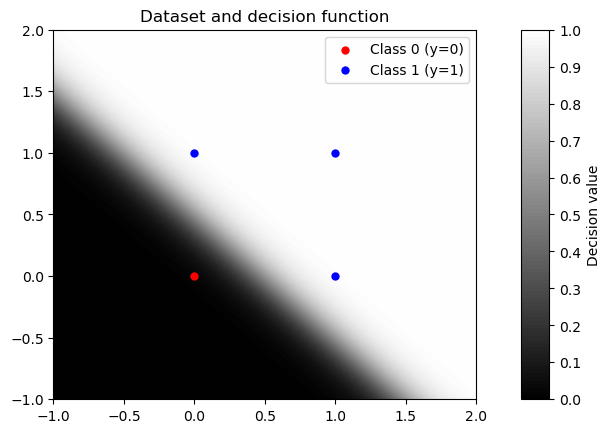

In [42]:
# Plot decision boundary
show_decision_boundary(perceptron, X, Y)